In [9]:
import glob
import os
import json
import pickle
import yaml
import math

import uproot

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import pyarrow.parquet as pq
from sklearn.metrics import auc, roc_curve
from scipy.special import softmax

import hist as hist2
import matplotlib.pyplot as plt
import mplhep as hep

plt.style.use(hep.style.CMS)

import sys
sys.path
sys.path.append("../python/")

import utils

plt.rcParams.update({"font.size": 20})

In [10]:
! ls ../eos/postprocessNov12_2017/SingleElectron_Run2017E/outfiles/0-20.pkl

../eos/postprocessNov12_2017/SingleElectron_Run2017E/outfiles/0-20.pkl


In [38]:
%load_ext autoreload
%autoreload 2

In [12]:
# get lumi
with open("../fileset/luminosity.json") as f:
    luminosity = json.load(f)
    
luminosity

{'ele': {'Run2': 137640.0,
  '2016APV': 19492.72,
  '2016': 16809.96,
  '2017': 41476.02,
  '2018': 59816.23},
 'mu': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96},
 'lep': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96}}

In [4]:
full_lumi = luminosity["lep"]["Run2"]
full_lumi = full_lumi/1000
full_lumi

137.64

In [26]:
# get lumi
import pickle as pkl
with open("../combine/templates/v1/hists_templates_Run2.pkl", "rb") as f:
    h = pkl.load(f)

In [27]:
h

Hist(
  StrCategory(['Data', 'DYJets', 'VBF', 'VH', 'WJetsLNu', 'TTbar', 'SingleTop', 'ggF', 'Diboson', 'QCD', 'WZQQ', 'ttH'], growth=True, name='Sample'),
  StrCategory(['nominal'], growth=True, name='Systematic'),
  StrCategory(['SR1995ParT', 'SR1999ParT', 'SR199ParT', 'SR1985ParT', 'SR198ParT', 'SR1975ParT', 'SR197ParT', 'SR1965ParT', 'SR196ParT', 'SR1955ParT', 'SR195ParT', 'SR1995', 'SR199', 'SR1985', 'SR198', 'SR1975', 'SR197', 'SR1965', 'SR196', 'SR1955', 'SR195', 'SR1ggF99', 'SR1ggF985', 'SR1ggF98', 'SR1ggF975', 'SR1ggF97', 'SR1ggF965', 'SR1ggF96', 'SR1ggF955', 'SR1ggF95', 'VBF98', 'VBF975', 'VBF97', 'VBF965', 'VBF96', 'VBF955', 'VBF95', 'SR1ggF985pt250to300', 'SR1ggF985pt300to450', 'SR1ggF985pt450toInf', 'SR1ggF98pt250to300', 'SR1ggF98pt300to450', 'SR1ggF98pt450toInf', 'SR1ggF975pt250to300', 'SR1ggF975pt300to450', 'SR1ggF975pt450toInf', 'SR1ggF97pt250to300', 'SR1ggF97pt300to450', 'SR1ggF97pt450toInf', 'SR1ggF965pt250to300', 'SR1ggF965pt300to450', 'SR1ggF965pt450toInf', 'SR1ggF9

In [231]:
# h[{"Sample": "DYJets", "Systematic": "weight_W_d3kappa_EWUp", "Region": "SR1ggFpt450toInf"}].values()

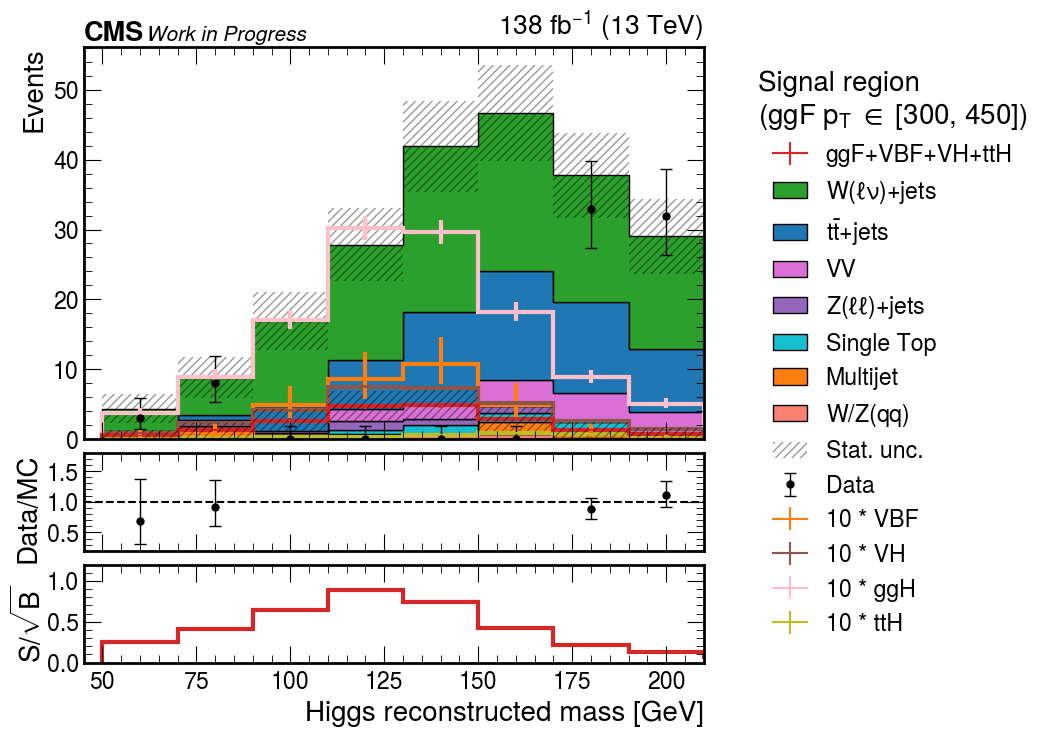

In [67]:
region = "VBF97"
text = "Signal region \n"  + r"(VBF catgeory)"


# region = "SR1ggF98pt250to300"
# text = "Signal region \n"  + r"(ggF $p_T$ $\in$ [250, 300])"

region = "SR1ggF98pt300to450"
text = "Signal region \n"  + r"(ggF $p_T$ $\in$ [300, 450])"

# region = "SR1ggF98pt450toInf"
# text = "Signal region \n"  + r"(ggF $p_T$ $\in$ [450, Inf])"

plt.rcParams.update({"font.size": 20})
add_data = True


if region.startswith("SR"):
    add_soverb=True
    blind_region=[90,160]
    if "VBF" in region:
        mult=5
    else:
        mult=10
else:
    add_soverb=True
    blind_region=None
    blind_region=[90,160]
    mult=1


years = ["2018", "2017", "2016", "2016APV"]
channels = ["ele", "mu"]

from utilsCombine import plot_hists
plot_hists(years, channels, hists=h[{"Systematic": "nominal", "Region": region}],
            add_data=add_data,
            logy=False,
            add_soverb=add_soverb,
            only_sig=False,
            mult=mult,
            outpath=f"/Users/fmokhtar/Desktop/AN/",
#             text_="Signal Regions",
#            text_=region,
#            text_="Signal region \n (VBF category)",
#            text_="Signal region \n"  + r"(ggF $p_T$ $\in$ [250, 300])",
           text_=text,
#            text_=r"Signal region \n (ggF $p_T$ $\in$ [450, inf])",           

            blind_region=blind_region,
          )

In [68]:
(1.45**2 + 1.8**2)**0.5

2.311384866265244

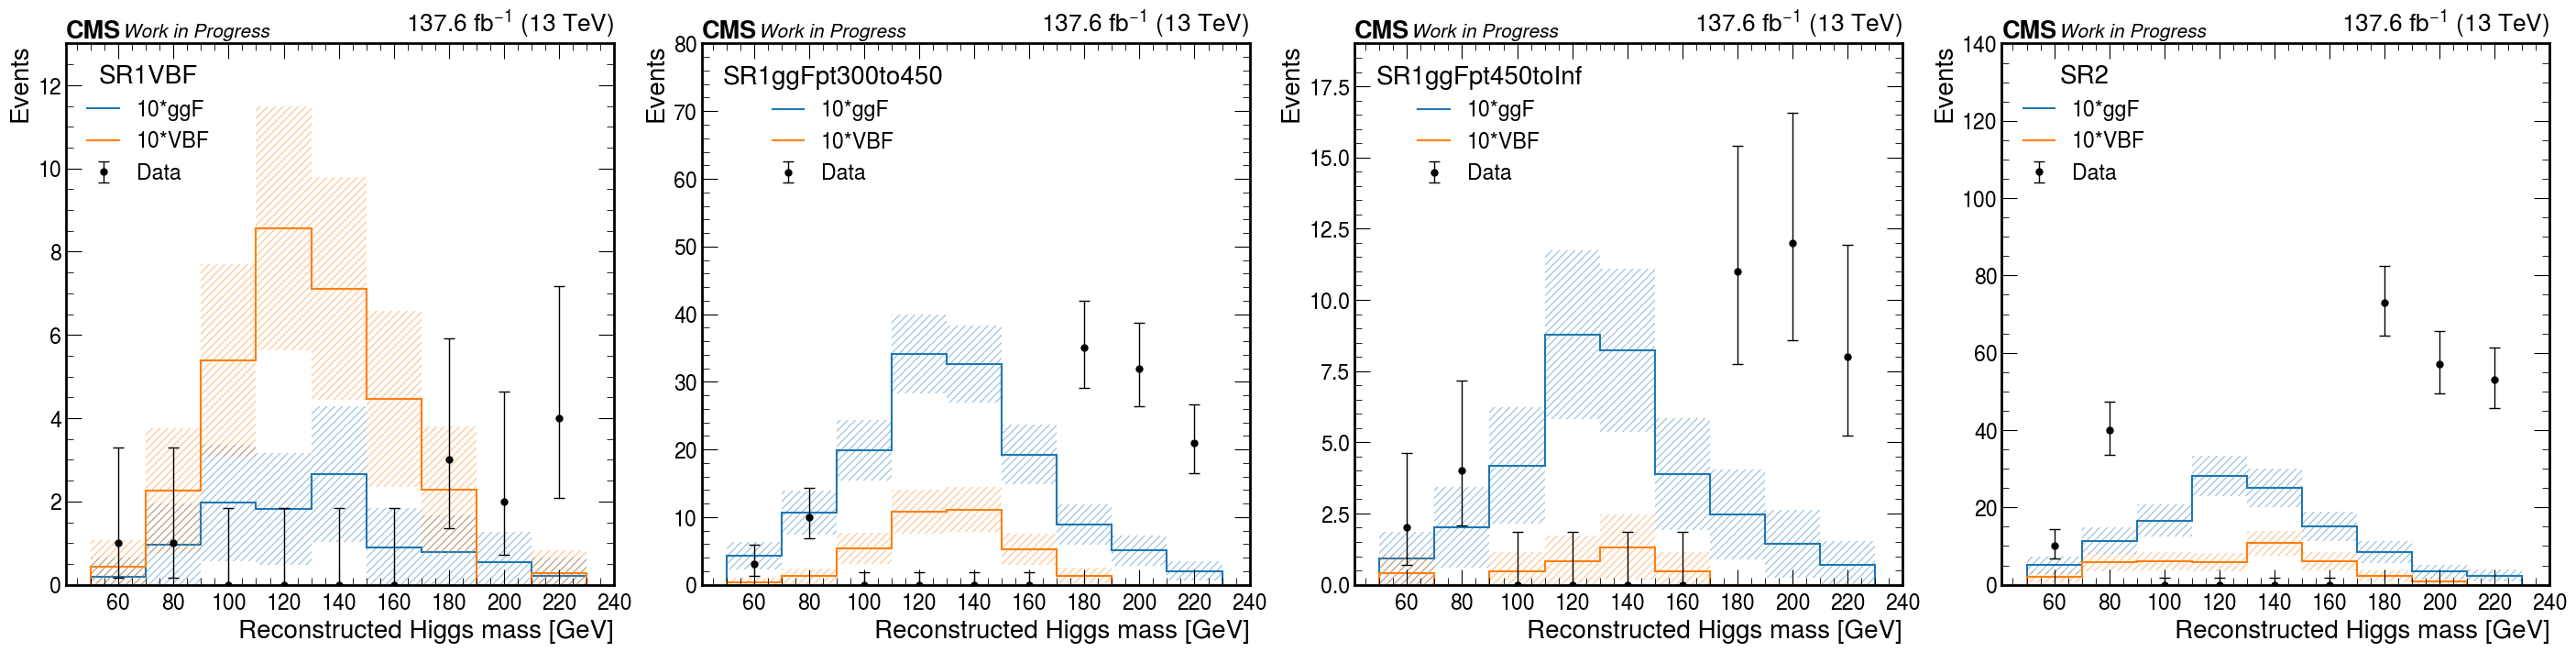

In [76]:
################### option 2
def blindBins(h, blind_region, blind_samples=[]):
    """
    Blind (i.e. zero) bins in histogram ``h``.
    If ``blind_samples`` specified, only blind those samples, else blinds all.

    CAREFUL: assumes axis=0 is samples, axis=3 is mass_axis

    """

    h = h.copy()

    massbins = h.axes["mass_observable"].edges

    lv = int(np.searchsorted(massbins, blind_region[0], "right"))
    rv = int(np.searchsorted(massbins, blind_region[1], "left") + 1)

    if blind_samples:
        for blind_sample in blind_samples:
            sample_index = np.argmax(np.array(list(h.axes[0])) == blind_sample)
            h.view(flow=True)[sample_index, :, :, lv:rv].value = 0
            h.view(flow=True)[sample_index, :, :, lv:rv].variance = 0            

    else:
        h.view(flow=True)[:, :, :, lv:rv].value = 0
        h.view(flow=True)[:, :, :, lv:rv].variance = 0        

    return h

sigcolor = {
    "ggF": "tab:blue",
    "VBF": "tab:orange",
}

errps = {
        "hatch": "////",
        "facecolor": "none",
        "lw": 0,
        "color": "tab:grey",
        "linewidth": 0,
        "alpha": 0.4,
}

fig, axs = plt.subplots(1, 4, figsize=(28,7), constrained_layout=True)

regions = ["SR1VBF", "SR1ggFpt300to450", "SR1ggFpt450toInf", "SR2"]
mult = 10

for i, region in enumerate(regions):
    if region=="SR2":
        i=3
    for sample in ["ggF", "VBF", "Data"]:


        if sample == "Data":
            hists = blindBins(hists, (blind_region[0],blind_region[1]), blind_samples=["Data"])

            hep.histplot(
                hists[{"Sample": sample, "Region": region, "Systematic": "nominal"}],
                ax=axs[i],
                label=sample,
                histtype="errorbar",
                color="k",
                capsize=4,   
                flow="none"                    

            )   

        else:
            if mult==1:
                lab = sample            
            else:
                lab = f"{mult}*{sample}"

            X = (hists[{"Sample": sample, "Region": region, "Systematic": "nominal"}] * mult).values()
            hep.histplot(             
                X,
                bins=list(range(50, 240, 20)),
                ax=axs[i],
                histtype="step",
                label=lab,
                flow="none",   
                color=sigcolor[sample],
            )   
            errps["color"] = sigcolor[sample]
            axs[i].stairs(
                values= X + np.sqrt(X),
                baseline= X - np.sqrt(X),
                edges=list(range(50, 240, 20)),
                **errps,
#                 label="Stat. unc.",
            )
            
    axs[i].legend(title=f"{region}", loc="upper left")

    if i==0:
        axs[i].set_ylim(0, 13)
    elif i==1:
        axs[i].set_ylim(0, 80)
    elif i==2:
        axs[i].set_ylim(0, 19)
    elif i==3:
        axs[i].set_ylim(0, 140)

    axs[i].set_ylabel(f"Events")
    axs[i].set_xlabel(f"Reconstructed Higgs mass [GeV]")
    axs[i].set_ylim(0)    
    hep.cms.lumitext("%.1f " % full_lumi + r"fb$^{-1}$ (13 TeV)", ax=axs[i], fontsize=20)
    hep.cms.text("Work in Progress", ax=axs[i], fontsize=15)

    axs[i].set_xticks(np.array(list(range(50, 240, 20))) + 10)
plt.savefig(f"/Users/fmokhtar/Desktop/AN/combine.pdf")

In [47]:
X.values()

array([0.19821861, 0.96343278, 1.96646094, 1.8200417 , 2.65175036,
       0.88898091, 0.78247256, 0.54265966, 0.20723599])

In [90]:
f["shapes_fit_s"]["SR1Blinded/total_signal"].values()*binwidth

array([4.82821699e-11, 1.02990255e-10, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.97130298e-10, 9.46164119e-11, 4.60173948e-11,
       2.43709584e-11], dtype=float32)

In [194]:
legend_lab = {
    "shapes_prefit": "Prefit",
    "shapes_fit_b": "B-Fit",
    "shapes_fit_s": "S+B-Fit"
}
color_by_sample = {
    "total_background": "tab:blue",
    "total_signal": "tab:red",
#     "ggF": "pink",
#     "VH": "tab:brown",
#     "VBF": "tab:gray",
#     "ttH": "tab:olive",
#     "DYJets": "tab:purple",
    "qcd": "tab:purple",
    "Diboson": "orchid",
#     "wjets": "tab:purple",
    "wjets": "tab:orange",    
    "ttbar": "tab:blue",
    "WZQQ": "salmon",
#     "SingleTop": "tab:cyan",
    "CMS_HWW_boosted_qcd_datadriven": "tab:orange",
    "CMS_HWW_boosted_wjets_datadriven": "tab:orange",
    "wjetsqcd": "tab:orange",
}


samples = [
    "data",
    "total_background",
    "total_signal",        
    "CMS_HWW_boosted_qcd_datadriven",
    "CMS_HWW_boosted_wjets_datadriven",    
    "wjets",    
    "wjetsqcd",        
#     "ttbar",
    "qcd",
]

def blindBins(X):
    X[2:6] = 0
    return X

can't find CMS_HWW_boosted_qcd_datadriven sample in shapes_prefit/SR2
can't find CMS_HWW_boosted_wjets_datadriven sample in shapes_prefit/SR2
can't find wjetsqcd sample in shapes_prefit/SR2
can't find CMS_HWW_boosted_qcd_datadriven sample in shapes_fit_b/SR2
can't find CMS_HWW_boosted_wjets_datadriven sample in shapes_fit_b/SR2
can't find wjetsqcd sample in shapes_fit_b/SR2
can't find CMS_HWW_boosted_qcd_datadriven sample in shapes_fit_s/SR2
can't find CMS_HWW_boosted_wjets_datadriven sample in shapes_fit_s/SR2
can't find wjetsqcd sample in shapes_fit_s/SR2


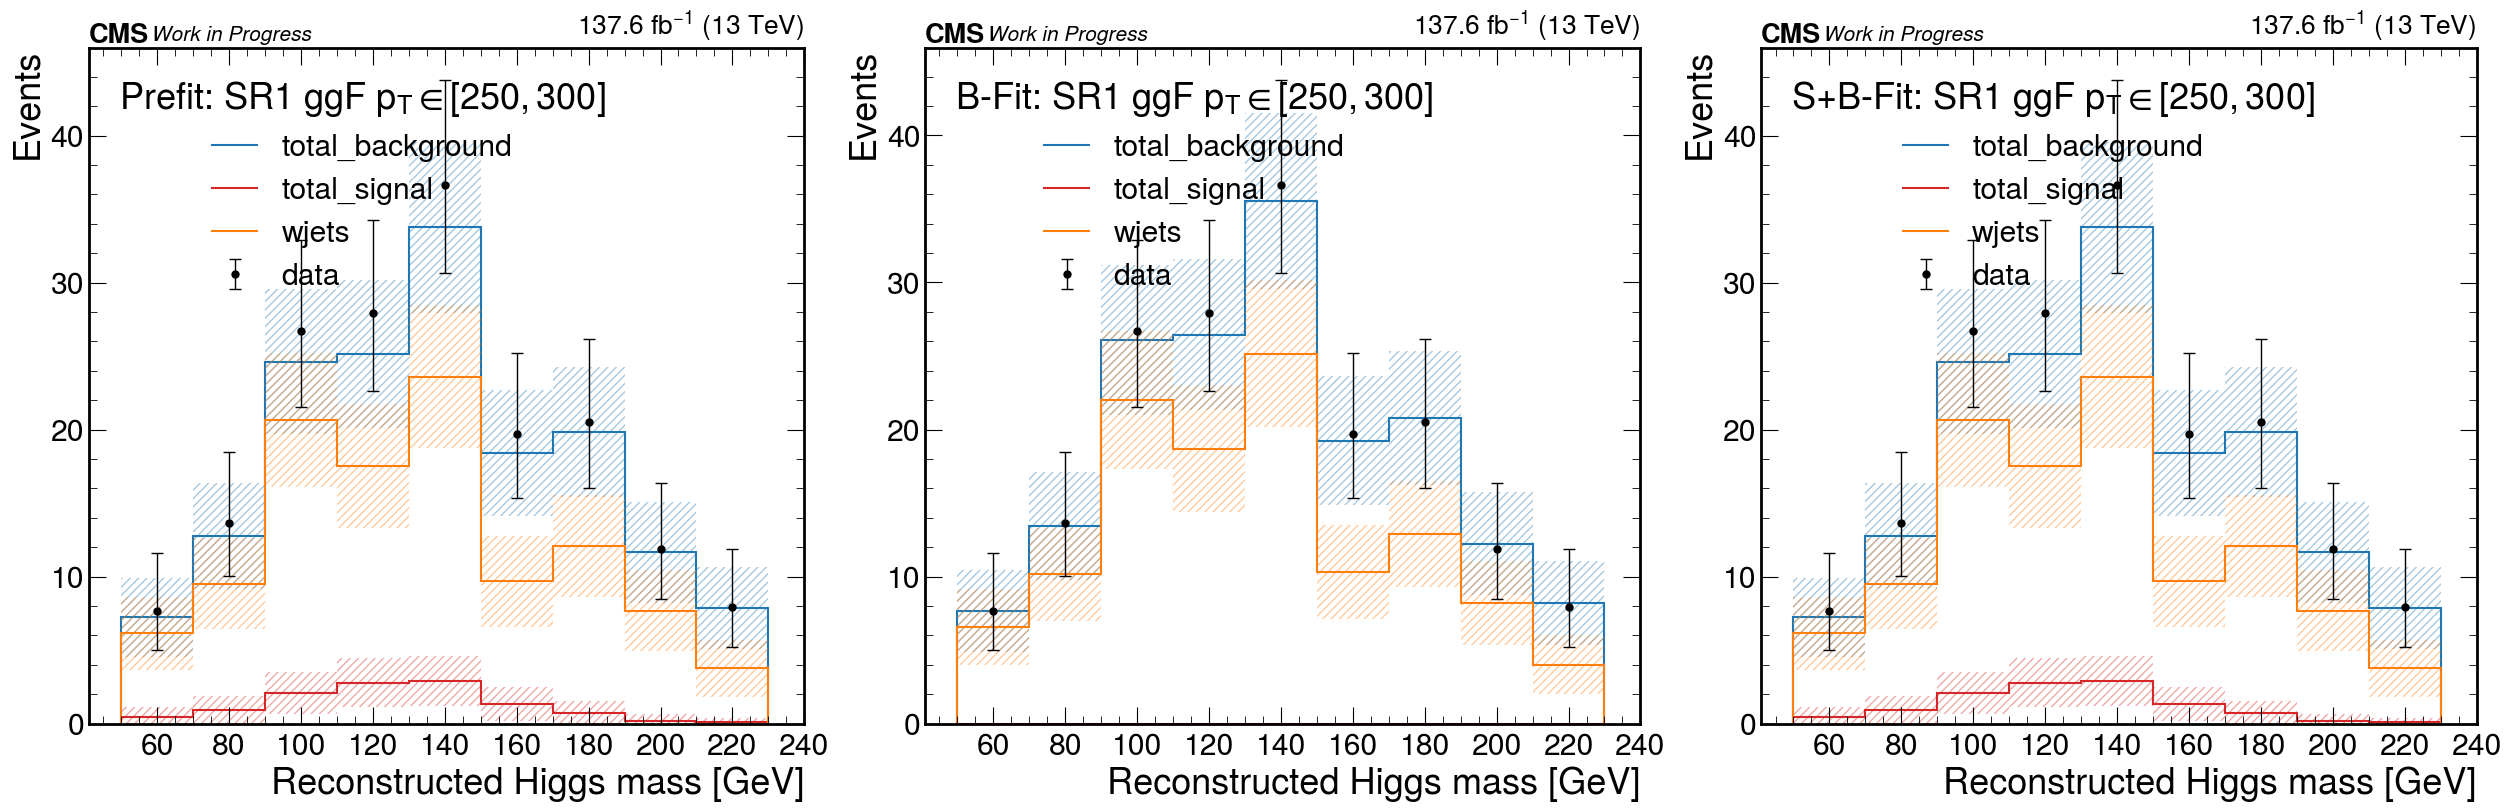

In [206]:
region_label_dict = {
    "SR1": r"$\mathrm{SR1} \ \mathrm{VBF}$",
    "SR2": r"$\mathrm{SR1} \ \mathrm{ggF} \ p_T \in [250, 300]$",    
    "SR3": r"$\mathrm{SR1} \ \mathrm{ggF} \ p_T \in [300, 450]$",
    "SR4": r"$\mathrm{SR1} \ \mathrm{ggF} \ p_T \in [450, \mathrm{Inf}]$",
    "SR5": r"$\mathrm{SR2}$",
    "CR": "Wjets CR",    
    "CR1": "Wjets CR",
    "CR2": "Wjets CR",
    "CR3": "Wjets CR",
    "CR4": "Wjets CR",   
}

f = uproot.open("fitDiagnosticsAsimov.root")
f = uproot.open("fitDiagnosticsAsimovRate.root")

binwidth = 20

region = "SR2"
# region = "CR"


# do = [f"shapes_prefit", f"shapes_fit_b"]
# do = [f"shapes_prefit", f"shapes_fit_s"]
do = [f"shapes_prefit", f"shapes_fit_b", "shapes_fit_s"]

errps = {
        "hatch": "////",
        "facecolor": "none",
        "lw": 0,
        "color": "tab:grey",
#         "edgecolor": (0, 0, 0, 0.5),
        "linewidth": 0,
        "alpha": 0.4,
}


if len(do) == 2:
    fig, axs = plt.subplots(1, 2, figsize=(17,8), constrained_layout=True)    
else:
    fig, axs = plt.subplots(1, 3, figsize=(25,8), constrained_layout=True)

for i, key in enumerate(do):

    for sample in samples:
        
#         if (sample == "total_signal") and (key=="shapes_fit_b"):
#             continue
        
#         if "qcd" in sample:
#             if region == "passBlinded2":
#                 sample += f"_pass"
#             else:
#                 sample += f"_{region}"
            
        if sample == "data":
            
            X = f[f"{key}/{region}"]["data"].values()[1]*binwidth
            
#             if "CR" not in region:
#                 X = blindBins(X)
            
            hep.histplot(
                X,
                bins=list(range(50, 240, binwidth)),
                ax=axs[i],
                label=sample,
                histtype="errorbar",
                color="k",
                capsize=4,    
#                 yerr="w2"
            )   

        else:
            
            if sample == "qcd" and "CR" not in region:
                continue
                
#             elif sample == "wjets":
#                 lab = "WJets+QCD (MC)"
#                 try:
#                     X = f[f"{key}/{region}"]["wjets"].values()*binwidth
#                     if "qcd;1" in f[f"{key}/{region}"].keys():
#                         X += f[f"{which_fit}/{region}"]["qcd"].values()*binwidth
#                 except KeyError:
#                     print(f"can't find {sample} sample in {key}/{region}")
#                     continue                    
            
#             else:
            try:
                X = f[f"{key}/{region}"][sample].values()*binwidth
            except KeyError:
                print(f"can't find {sample} sample in {key}/{region}")
                continue  
            lab = sample

            hep.histplot(             
                X,
                bins=list(range(50, 240, binwidth)),
                ax=axs[i],
                histtype="step",
                label=lab,
                color=color_by_sample[sample],
                flow="none",                
            )   
            errps["color"] = color_by_sample[sample]
            axs[i].stairs(
                values= X + np.sqrt(X),
                baseline= X - np.sqrt(X),
                edges=list(range(50, 240, binwidth)),
                **errps,
#                 label="Stat. unc.",
            )
            

    axs[i].legend(title=f"{legend_lab[key]}: {region_label_dict[region]}", loc="upper left")
    
    axs[i].set_ylabel(f"Events")
    axs[i].set_xlabel(f"Reconstructed Higgs mass [GeV]")
#     if region =="SR1":
#         axs[i].set_ylim(0, 9)
#     elif region =="SR2":
#         axs[i].set_ylim(0, 80)
#     elif region == "SR3":
#         axs[i].set_ylim(0, 19)
#     elif region == "SR4":
#         axs[i].set_ylim(0, 140)
#     elif region == "CR":
#         axs[i].set_ylim(0, 9500)
        
    axs[i].set_ylim(0)        
    
    hep.cms.lumitext("%.1f " % full_lumi + r"fb$^{-1}$ (13 TeV)", ax=axs[i], fontsize=20)
    hep.cms.text("Work in Progress", ax=axs[i], fontsize=15)

    axs[i].set_xticks(np.array(list(range(50, 240, 20))) + 10)
    
plt.savefig(f"/Users/fmokhtar/Desktop/AN/combine.pdf")        

# Old

can't find CMS_HWW_boosted_qcd_datadriven sample in shapes_prefit/SR2
can't find CMS_HWW_boosted_wjets_datadriven sample in shapes_prefit/SR2
can't find wjetsqcd sample in shapes_prefit/SR2
can't find CMS_HWW_boosted_qcd_datadriven sample in shapes_fit_b/SR2
can't find CMS_HWW_boosted_wjets_datadriven sample in shapes_fit_b/SR2
can't find wjetsqcd sample in shapes_fit_b/SR2
can't find CMS_HWW_boosted_qcd_datadriven sample in shapes_fit_s/SR2
can't find CMS_HWW_boosted_wjets_datadriven sample in shapes_fit_s/SR2
can't find wjetsqcd sample in shapes_fit_s/SR2


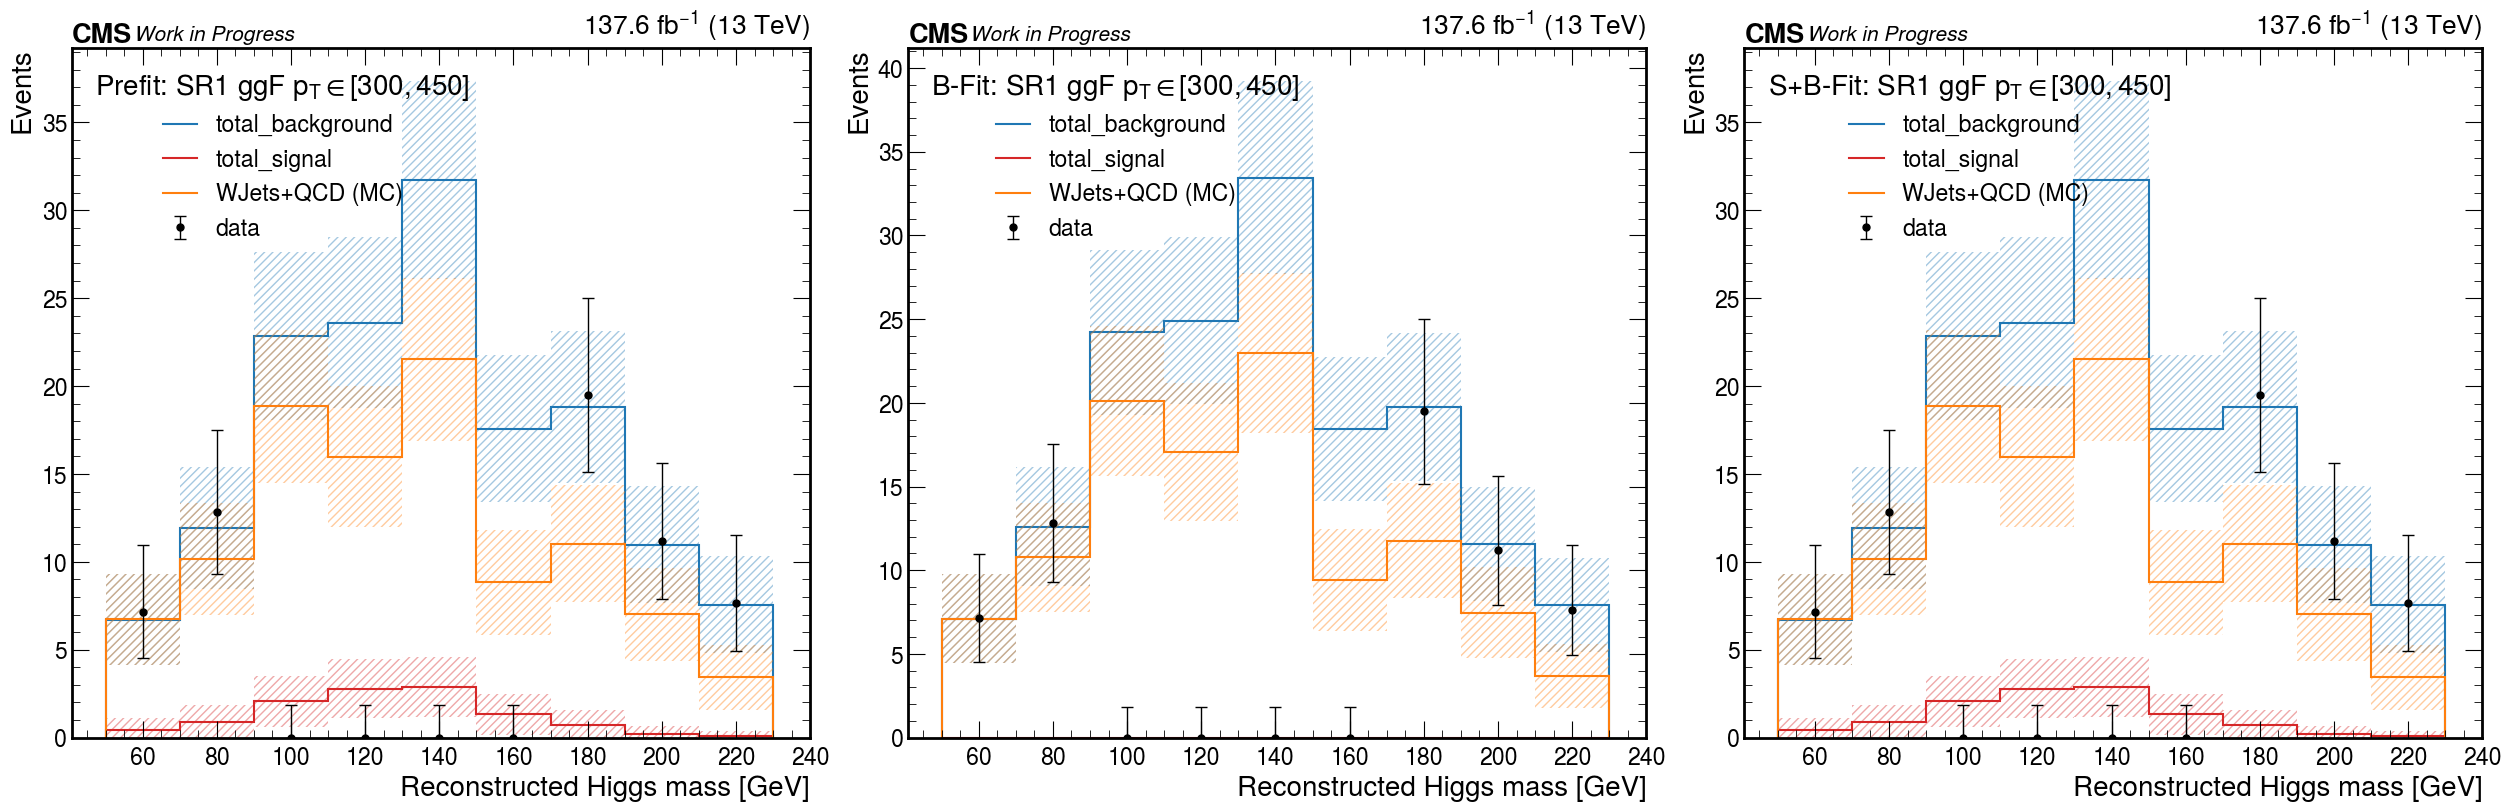

In [189]:
region_label_dict = {
    "SR1": r"$\mathrm{SR1} \ \mathrm{VBF}$",
    "SR2": r"$\mathrm{SR1} \ \mathrm{ggF} \ p_T \in [300, 450]$",
    "SR3": r"$\mathrm{SR1} \ \mathrm{ggF} \ p_T \in [450, \mathrm{Inf}]$",
    "SR4": r"$\mathrm{SR2}$",
    "CR": "Wjets CR",    
    "CR1": "Wjets CR",
    "CR2": "Wjets CR",
    "CR3": "Wjets CR",
    "CR4": "Wjets CR",   
}
f = uproot.open("fitDiagnosticsTestMC.root")
f = uproot.open("fitDiagnosticsTestRhalphabet.root")
f = uproot.open("fitDiagnosticsTest.root")
f = uproot.open("fitDiagnosticsAsimov.root")

binwidth = 20

region = "SR2"
# region = "CR"

if region=="TopCR":
    samples = samplestop
else:
    samples = samplesSR


# do = [f"shapes_prefit", f"shapes_fit_b"]
# do = [f"shapes_prefit", f"shapes_fit_s"]
do = [f"shapes_prefit", f"shapes_fit_b", "shapes_fit_s"]

errps = {
        "hatch": "////",
        "facecolor": "none",
        "lw": 0,
        "color": "tab:grey",
#         "edgecolor": (0, 0, 0, 0.5),
        "linewidth": 0,
        "alpha": 0.4,
}


if len(do) == 2:
    fig, axs = plt.subplots(1, 2, figsize=(17,8), constrained_layout=True)    
else:
    fig, axs = plt.subplots(1, 3, figsize=(25,8), constrained_layout=True)

for i, key in enumerate(do):

    for sample in samples:
        
#         if (sample == "total_signal") and (key=="shapes_fit_b"):
#             continue
        
#         if "qcd" in sample:
#             if region == "passBlinded2":
#                 sample += f"_pass"
#             else:
#                 sample += f"_{region}"
            
        if sample == "data":
            
            X = f[f"{key}/{region}"]["data"].values()[1]*binwidth
            
            if "CR" not in region:
                X = blindBins(X)
            
            hep.histplot(
                X,
                bins=list(range(50, 240, binwidth)),
                ax=axs[i],
                label=sample,
                histtype="errorbar",
                color="k",
                capsize=4,    
#                 yerr="w2"
            )   

        else:
            
            
            if (sample == "CMS_HWW_boosted_qcd_datadriven") or (sample == "CMS_HWW_boosted_wjets_datadriven"):
                lab = "WJets+QCD (data-driven)"
                try:
                    X = f[f"{key}/{region}"][sample].values()*binwidth
                except KeyError:
                    print(f"can't find {sample} sample in {key}/{region}")
                    continue

            elif sample == "qcd":
                continue
                
            elif sample == "wjets":
                lab = "WJets+QCD (MC)"
                try:
                    X = f[f"{key}/{region}"]["wjets"].values()*binwidth
                    if "qcd;1" in f[f"{key}/{region}"].keys():
                        X += f[f"{which_fit}/{region}"]["qcd"].values()*binwidth
                except KeyError:
                    print(f"can't find {sample} sample in {key}/{region}")
                    continue                    
            
            else:
                try:
                    X = f[f"{key}/{region}"][sample].values()*binwidth
                except KeyError:
                    print(f"can't find {sample} sample in {key}/{region}")
                    continue  
                lab = sample

            hep.histplot(             
                X,
                bins=list(range(50, 240, binwidth)),
                ax=axs[i],
                histtype="step",
                label=lab,
                color=color_by_sample[sample],
                flow="none",                
            )   
            errps["color"] = color_by_sample[sample]
            axs[i].stairs(
                values= X + np.sqrt(X),
                baseline= X - np.sqrt(X),
                edges=list(range(50, 240, binwidth)),
                **errps,
#                 label="Stat. unc.",
            )
            

    axs[i].legend(title=f"{legend_lab[key]}: {region_label_dict[region]}", loc="upper left")
    
    axs[i].set_ylabel(f"Events")
    axs[i].set_xlabel(f"Reconstructed Higgs mass [GeV]")
#     if region =="SR1":
#         axs[i].set_ylim(0, 9)
#     elif region =="SR2":
#         axs[i].set_ylim(0, 80)
#     elif region == "SR3":
#         axs[i].set_ylim(0, 19)
#     elif region == "SR4":
#         axs[i].set_ylim(0, 140)
#     elif region == "CR":
#         axs[i].set_ylim(0, 9500)
        
    axs[i].set_ylim(0)        
    
    hep.cms.lumitext("%.1f " % full_lumi + r"fb$^{-1}$ (13 TeV)", ax=axs[i], fontsize=20)
    hep.cms.text("Work in Progress", ax=axs[i], fontsize=15)

    axs[i].set_xticks(np.array(list(range(50, 240, 20))) + 10)
    
plt.savefig(f"/Users/fmokhtar/Desktop/AN/combine.pdf")        

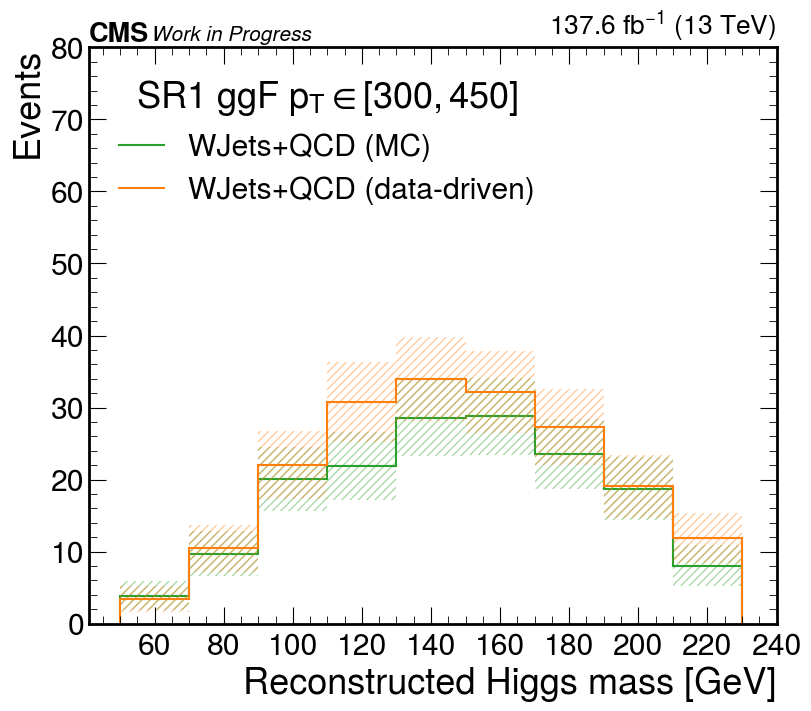

In [102]:
region_label_dict = {
    "SR1": r"$\mathrm{SR1} \ \mathrm{VBF}$",
    "SR2": r"$\mathrm{SR1} \ \mathrm{ggF} \ p_T \in [300, 450]$",
    "SR3": r"$\mathrm{SR1} \ \mathrm{ggF} \ p_T \in [450, \mathrm{Inf}]$",
    "SR4": r"$\mathrm{SR2}$",
    "CR": "Wjets CR",    
    "CR1": "Wjets CR",
    "CR2": "Wjets CR",
    "CR3": "Wjets CR",
    "CR4": "Wjets CR",   
}
errps = {
        "hatch": "////",
        "facecolor": "none",
        "lw": 0,
        "color": "tab:grey",
#         "edgecolor": (0, 0, 0, 0.5),
        "linewidth": 0,
        "alpha": 0.4,
}


binwidth = 20
region = "SR2"
# region = "CR"
which_fit = "shapes_fit_b"

fig, ax = plt.subplots(figsize=(8,7), constrained_layout=True)

# plot MC
f = uproot.open("fitDiagnosticsTestMC.root")
X = f[f"{which_fit}/{region}"]["wjets"].values()*binwidth
if "qcd;1" in f[f"{which_fit}/{region}"].keys():
    X += f[f"{which_fit}/{region}"]["qcd"].values()*binwidth
lab = "WJets+QCD (MC)"
hep.histplot(             
    X,
    bins=list(range(50, 240, binwidth)),
    ax=ax,
    histtype="step",
    label=lab,
    color="tab:green",
    flow="none",                
)   
errps["color"] = "tab:green"
ax.stairs(
    values= X + np.sqrt(X),
    baseline= X - np.sqrt(X),
    edges=list(range(50, 240, binwidth)),
    **errps,
#                 label="Stat. unc.",
)

# plot rhalphabet
f = uproot.open("fitDiagnosticsTest.root")
X = f[f"{which_fit}/{region}"]["CMS_HWW_boosted_wjets_datadriven"].values()*binwidth
lab = "WJets+QCD (data-driven)"
hep.histplot(             
    X,
    bins=list(range(50, 240, binwidth)),
    ax=ax,
    histtype="step",
    label=lab,
    color=color_by_sample[sample],
    flow="none",                
)   
errps["color"] = color_by_sample[sample]
ax.stairs(
    values= X + np.sqrt(X),
    baseline= X - np.sqrt(X),
    edges=list(range(50, 240, binwidth)),
    **errps,
#                 label="Stat. unc.",
)

ax.legend(title=f"{region_label_dict[region]}", loc="upper left")

ax.set_ylabel(f"Events")
ax.set_xlabel(f"Reconstructed Higgs mass [GeV]")

if region =="SR1":
    ax.set_ylim(0, 9)
elif region =="SR2":
    ax.set_ylim(0, 80)
elif region == "SR3":
    ax.set_ylim(0, 19)
elif region == "SR4":
    ax.set_ylim(0, 140)
elif region == "CR":
    ax.set_ylim(0, 9500)    

hep.cms.lumitext("%.1f " % full_lumi + r"fb$^{-1}$ (13 TeV)", ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)

ax.set_xticks(np.array(list(range(50, 240, 20))) + 10);
    
plt.savefig(f"/Users/fmokhtar/Desktop/AN/combine.pdf")        

KeyInFileError: not found: 'wjets' (with any cycle number)

    Available keys: 'zjets;1', 'ttH;1', 'data;1', 'VH;1', 'VBF;1', 'ggF;1', 'ttbar;1', 'total;1', 'singletop;1', 'total_signal;1', 'total_covar;1', 'total_background;1', 'CMS_HWW_boosted_qcd_datadriven;1'

in file fitDiagnosticsTest.root

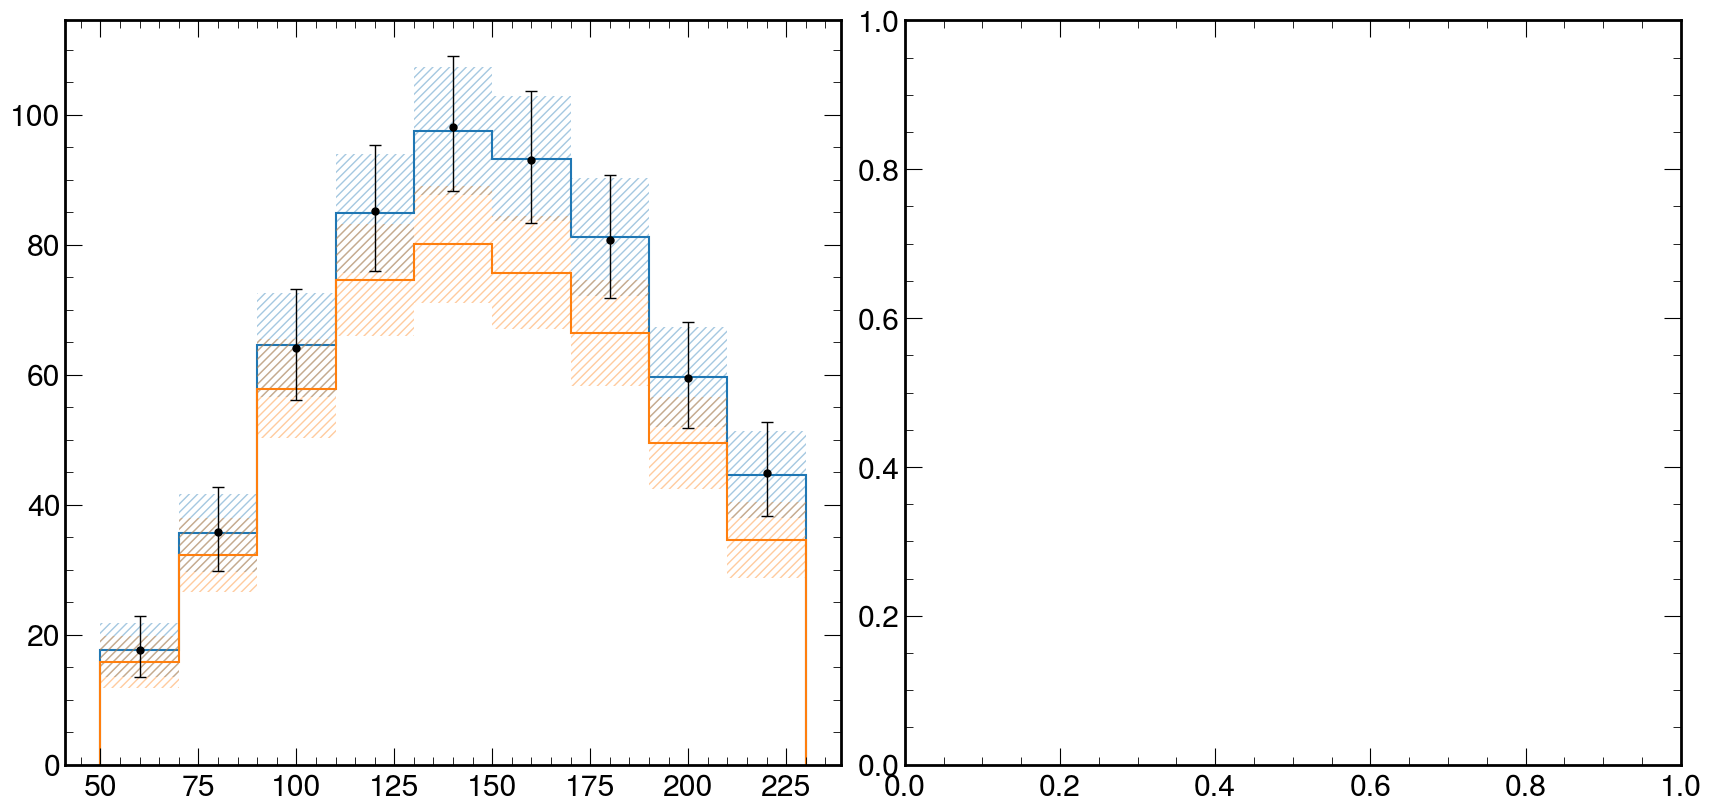

In [615]:
region_label_dict = {
    "SR1": r"$\mathrm{SR1} \ \mathrm{VBF}$",
    "SR2": r"$\mathrm{SR1} \ \mathrm{ggF} \ p_T \in [300, 450]$",
    "SR3": r"$\mathrm{SR1} \ \mathrm{ggF} \ p_T \in [450, \mathrm{Inf}]$",
    "SR4": r"$\mathrm{SR2}$",
    "CR": "Wjets CR",    
    "CR1": "Wjets CR",
    "CR2": "Wjets CR",
    "CR3": "Wjets CR",
    "CR4": "Wjets CR",   
}


binwidth = 20

# region = "SR1VBFBlinded"
# region = "WJetsCRforSR1VBFBlinded"

# region = "SR1ggFpt300to450Blinded"
# region = "WJetsCRforSR1ggFpt300to450Blinded"

# region = "SR1ggFpt450toInfBlinded"
# region = "WJetsCRforSR1ggFpt450toInfBlinded"

# region = "SR2"
# region = "WJetsCRforSR2"

region = "SR4"
# region = "CR"

if region=="TopCR":
    samples = samplestop
else:
    samples = samplesSR


errps = {
        "hatch": "////",
        "facecolor": "none",
        "lw": 0,
        "color": "tab:grey",
#         "edgecolor": (0, 0, 0, 0.5),
        "linewidth": 0,
        "alpha": 0.4,
}


do = [f"shapes_fit_b", f"shapes_fit_b"]
# do = [f"shapes_prefit", f"shapes_fit_s"]
# do = [f"shapes_prefit", f"shapes_fit_b", "shapes_fit_s"]

if len(do) == 2:
    fig, axs = plt.subplots(1, 2, figsize=(17,8), constrained_layout=True)    
else:
    fig, axs = plt.subplots(1, 3, figsize=(25,8), constrained_layout=True)

for i, key in enumerate(do):

    if i==0:
        f = uproot.open("fitDiagnosticsTest.root")
    else:
        f = uproot.open("fitDiagnosticsTestBlindingAndNotFreezing.root")
        
    for sample in samples:
        
        if (sample == "total_signal") and (key=="shapes_fit_b"):
            continue
        
#         if "qcd" in sample:
#             if region == "passBlinded2":
#                 sample += f"_pass"
#             else:
#                 sample += f"_{region}"
            
        if sample == "data":
            
            hep.histplot(
                f[f"{key}/{region}"]["data"].values()[1]*binwidth,
                bins=list(range(50, 240, 20)),
                ax=axs[i],
                label=sample,
                histtype="errorbar",
                color="k",
                capsize=4,           
            )   

        else:
            if i==0:
                if sample == "qcd":
                    continue

                if sample == "wjets":        
                    X = f[f"{key}/{region}"]["wjets"].values()*binwidth
                    
                    try:
                        X += f[f"{key}/{region}"]["qcd"].values()*binwidth
                    except KeyError:
                        print(f"can't find {sample} sample in {key}/{region}")
                        

                    lab = "WJets+QCD (MC)"
                else:
                    try:
                        X = f[f"{key}/{region}"][sample].values()*binwidth
                    except KeyError:
                        print(f"can't find {sample} sample in {key}/{region}")
                        continue
                    lab=sample
                
            if i==1:
                try:
                    X = f[f"{key}/{region}"][sample].values()*binwidth
                except KeyError:
                    print(f"can't find {sample} sample in {key}/{region}")
                    continue
                    
                if "qcd" in sample:
                    lab = "WJets+QCD (data-driven)"
                else:
                    lab = sample
                
            hep.histplot(             
                X,
                bins=list(range(50, 240, 20)),
                ax=axs[i],
                histtype="step",
                label=lab,
                color=color_by_sample[sample],
                flow="none",                
            )   
            errps["color"] = color_by_sample[sample]
            axs[i].stairs(
                values= X + np.sqrt(X),
                baseline= X - np.sqrt(X),
                edges=list(range(50, 240, 20)),
                **errps,
#                 label="Stat. unc.",
            )
                        
    
    axs[i].legend(title=f"{legend_lab[key]}: {region_label_dict[region]}", loc="upper left")
    
    axs[i].set_ylabel(f"Events")
    axs[i].set_xlabel(f"Reconstructed Higgs mass [GeV]")
#     if region =="SR2":
#         axs[i].set_ylim(0, 10)
#     elif region == "SR3":
#         axs[i].set_ylim(0, 19)
#     elif region == "SR4":
#         axs[i].set_ylim(0, 140)
        
    axs[i].set_ylim(0,120)        
    
    hep.cms.lumitext("%.1f " % full_lumi + r"fb$^{-1}$ (13 TeV)", ax=axs[i], fontsize=20)
    hep.cms.text("Work in Progress", ax=axs[i], fontsize=15)

    axs[i].set_xticks(np.array(list(range(50, 240, 20))) + 10)
    
plt.savefig(f"/Users/fmokhtar/Desktop/AN/combine.pdf")        

In [212]:
a

'llaa'

In [80]:
b

'llaa'

In [247]:
f["shapes_prefit"]["SR1Blinded/total_signal"].values()*binwidth

array([1.3749026 , 2.9327927 , 0.        , 0.        , 0.        ,
       5.6135616 , 2.6943355 , 1.31041   , 0.69399726], dtype=float32)

In [248]:
f["shapes_fit_s"]["SR1Blinded/total_signal"].values()*binwidth

array([ 6.932394 , 14.77989  ,  0.       ,  0.       ,  0.       ,
       28.318079 , 13.587323 ,  6.60555  ,  3.4993017], dtype=float32)

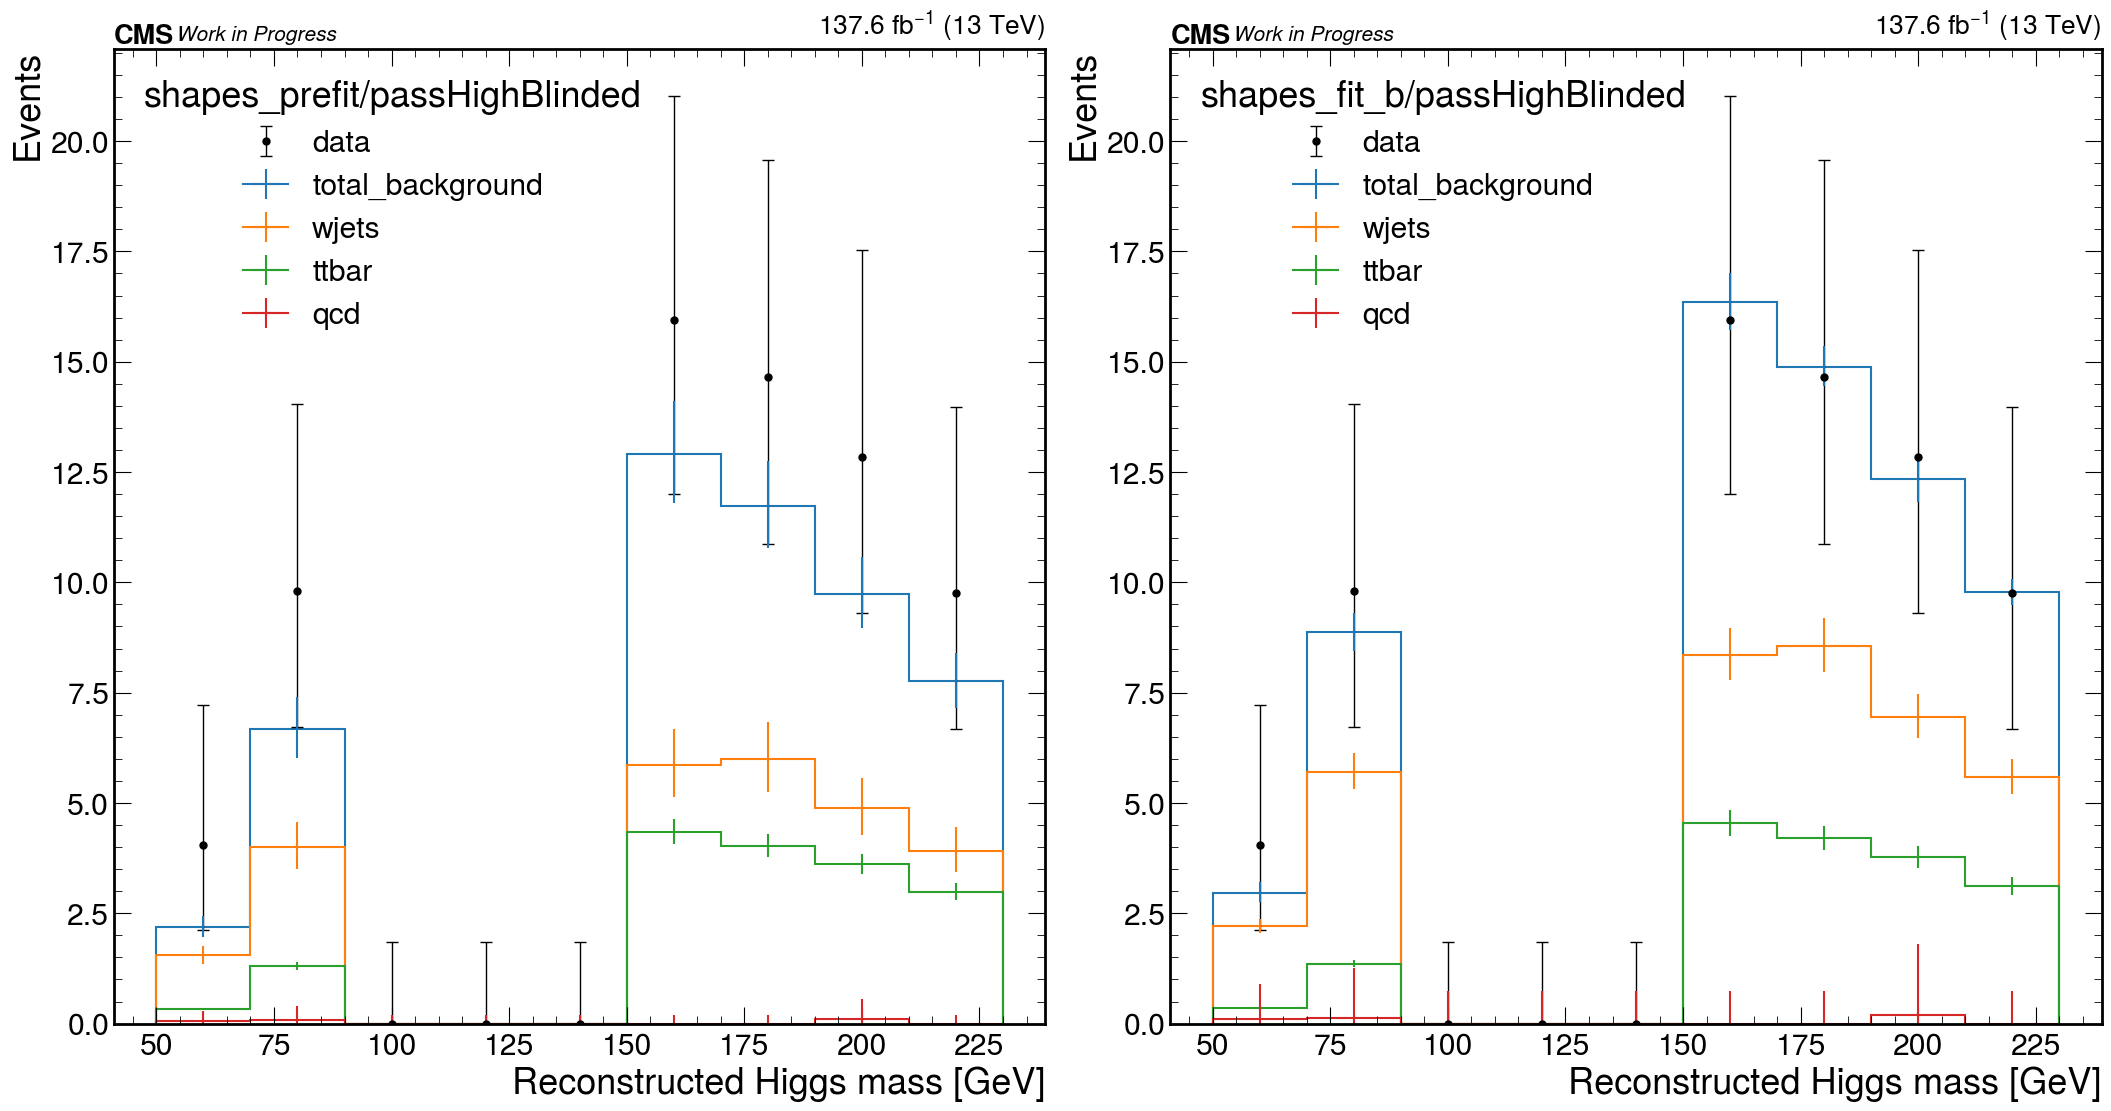

In [130]:
# region = "wjetsCR"
# region = "passMediumBlinded"
region = "passHighBlinded"

fig, axs = plt.subplots(1, 2, figsize=(21,11), constrained_layout=True)
for i, key in enumerate([f"shapes_prefit/{region}", f"shapes_fit_b/{region}"]):

    for sample in samples:
#         if "qcd" in sample:
#             if region == "passBlinded2":
#                 sample += f"_pass"
#             else:
#                 sample += f"_{region}"
            
        if sample == "data":
            
            hep.histplot(
                f[key]["data"].values()[1],
                bins=list(range(50, 240, 20)),
                ax=axs[i],
                label=sample,
                histtype="errorbar",
                color="k",
                capsize=4,           
            )   

        else:
#             if "qcd" in sample:
#                 lab = "QCD (data-driven)"
#             else:
#                 lab = sample
            lab = sample

            hep.histplot(             
                f[key][sample],
                ax=axs[i],
                histtype="step",
                label=lab,
            )    

    axs[i].legend(title=key, loc="upper left")
    axs[i].set_ylabel(f"Events")
    axs[i].set_xlabel(f"Reconstructed Higgs mass [GeV]")
    axs[i].set_ylim(0)   
    
    hep.cms.lumitext("%.1f " % full_lumi + r"fb$^{-1}$ (13 TeV)", ax=axs[i], fontsize=20)
    hep.cms.text("Work in Progress", ax=axs[i], fontsize=15)

plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku5/combine_bfit.pdf")        

In [17]:
samples = [
#     "data",
    "total_background",
    "total_signal",
#     "CMS_HWW_boosted_qcd_datadriven",
    "wjets",    
    "ttbar",
    "zjets",
    "singletop",
    "total_covar"
]

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Work in Progress'))

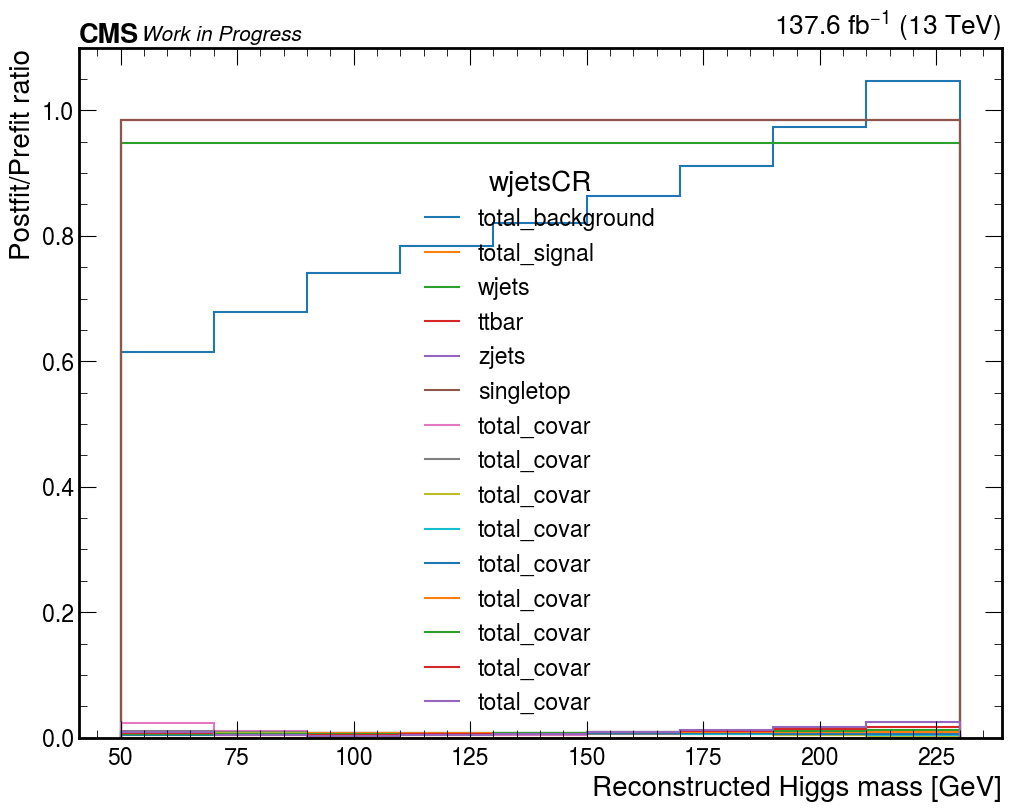

In [10]:
region = "wjetsCR"

if region=="pass":
    region += "Blinded"

fig, ax = plt.subplots(figsize=(10,8), constrained_layout=True)
for sample in samples:


    if sample == "data":
        num = f[f"shapes_fit_b/{region}"]["data"].values()[1]
        den = f[f"shapes_prefit/{region}"]["data"].values()[1]

        hep.histplot(
            num/den,
            bins=list(range(50, 240, 20)),
            ax=ax,
            label=sample,
            histtype="errorbar",
            color="k",
            capsize=4,           
        )   

    else:
        num = f[f"shapes_fit_b/{region}"][sample].values()
        den = f[f"shapes_prefit/{region}"][sample].values()

        hep.histplot(
            num/den,
            bins=list(range(50, 240, 20)),
            ax=ax,
            histtype="step",
            label=sample,
        )    

ax.legend(title=region)
ax.set_ylabel(f"Postfit/Prefit ratio")
ax.set_xlabel(f"Reconstructed Higgs mass [GeV]")
ax.set_ylim(0)    
hep.cms.lumitext("%.1f " % full_lumi + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)

In [428]:
f["shapes_prefit/passBlinded"]["wjets"].values()

array([1.4160691, 3.8754134, 0.       , 0.       , 0.       , 5.597086 ,
       5.7969   , 4.6152887, 3.6734428], dtype=float32)